# A.5 onwards

This testing document more effectively creates an RFM model ready for clustering by using log transformations and percentile ranking on the monetary values.

In [3]:
import pandas
import numpy

df = pandas.read_csv("bankTransactions_rfm.csv")
print(df.head())

  CustomerID  Recency  Frequency  Monetary
0   C1010011       75          2    4750.0
1   C1010012      118          1    1499.0
2   C1010014      155          2    1205.0
3   C1010018       86          1      30.0
4   C1010024      114          1    5000.0


In [4]:
# Percentage Values for Recency

def RecencyPerc(df) :
  perc = (df / df.max()) * 100
  return 100 - perc

In [5]:
# Percentage Values for Frequency

def FrequencyPerc(df) :
  perc = (df / df.max()) * 100
  return perc

In [6]:
# Log transformation for Monetary
# WE CAN USE LOG(x) HERE BUT WE USE LOG1P(x) BECAUSE IT'S STANDARD PRACTICE AND TO AVOID LOG(0) ERROR

df['Monetary'] = numpy.log1p(df['Monetary'])

In [7]:
# Percentile Ranking Monetary
# DOING THE LOG TRANSFORMAITON AND PERCENTILE RANKING SHOULD REMOVE SKEW FROM THE MONETARY DATA BECAUSE
# LOG WILL SQUISH THE DATA AND PERCENTILE RANKING WILL COMPARE THE DATA WITH ITS NEIGHBOURS TO PUT IT INTO RANKS

df['Monetary'] = df['Monetary'].rank(pct=True) * 100

In [8]:
# Concatenate into Normalised Model

normalisedRFM = pandas.DataFrame({
    'Customer ID': df['CustomerID'],
    'Recency': RecencyPerc(df['Recency']),
    'Frequency': FrequencyPerc(df['Frequency']),
    'Monetary': df['Monetary']
})

print(normalisedRFM.round().head())

  Customer ID  Recency  Frequency  Monetary
0    C1010011     78.0       33.0      94.0
1    C1010012     65.0       17.0      77.0
2    C1010014     54.0       33.0      73.0
3    C1010018     74.0       17.0       5.0
4    C1010024     66.0       17.0      94.0


In [9]:
# RFM categorisation

def CustomerAssignment(row):
    r = row['Recency']
    f = row['Frequency']
    m = row['Monetary']

    if (r >= 80) and (f >= 80) and (m >= 80):
        return 'Best Customer'
    elif (r >= 65) and (f >= 70) and (m >= 70):
        return 'Loyal'
    elif (r >= 70) and (f >= 40) and (m >= 40):
        return 'Potential Loyalist'
    elif (r >= 50) and (f >= 40) and (m < 50):
        return 'Promising'
    elif (r < 40) and (f >= 50):
        return 'Customers Needing Attention'
    elif (r < 40) and (f < 40) and (m >= 40):
        return 'At Risk'
    elif (r < 25) and (f < 25) and (m < 40):
        return 'Hibernating'
    else:
        return 'Lost'


normalisedRFM[['Recency', 'Frequency', 'Monetary']] = normalisedRFM[['Recency', 'Frequency', 'Monetary']].astype(int)

normalisedRFM['CustomerGroup'] = normalisedRFM.apply(CustomerAssignment, axis=1)
print(normalisedRFM.head())

  Customer ID  Recency  Frequency  Monetary CustomerGroup
0    C1010011       77         33        93          Lost
1    C1010012       64         16        77          Lost
2    C1010014       54         33        73          Lost
3    C1010018       74         16         4          Lost
4    C1010024       66         16        94          Lost


In [10]:
groups = [
    'Best Customer',
    'Loyal',
    'Potential Loyalist',
    'Promising',
    'Customers Needing Attention',
    'At Risk',
    'Hibernating',
    'Lost',
]

def CustomerGroupOverview() :
    for group in groups :
        print(normalisedRFM[normalisedRFM['CustomerGroup'] == group])

#CustomerGroupOverview()

normalisedRFM['CustomerGroup'].value_counts()


,count
CustomerGroup,
Lost,696576
At Risk,90819
Hibernating,39721
Potential Loyalist,9683
Promising,1529
Customers Needing Attention,140
Loyal,59
Best Customer,34


# Plotted results on scatter map


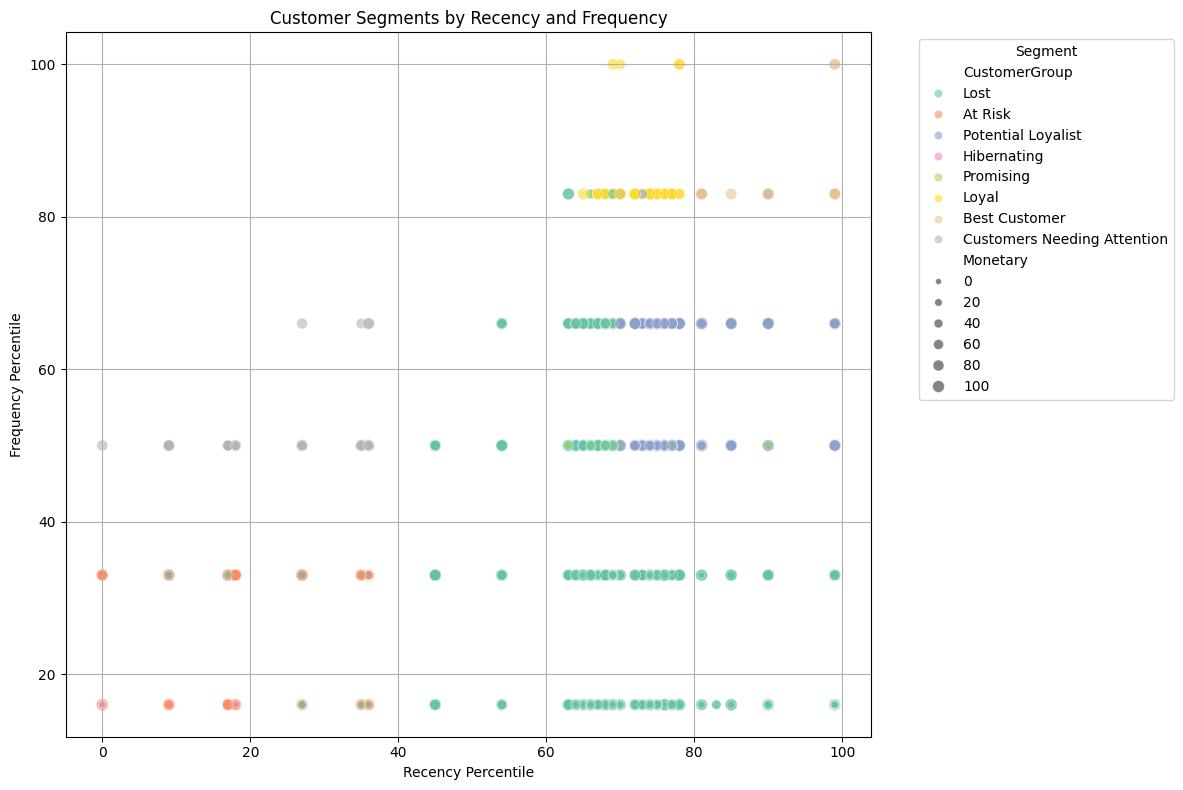

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=normalisedRFM,
    x='Recency',
    y='Frequency',
    hue='CustomerGroup',
    palette='Set2',
    alpha=0.6,
    size='Monetary'
)

plt.title('Customer Segments by Recency and Frequency')
plt.xlabel('Recency Percentile')
plt.ylabel('Frequency Percentile')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
print(normalisedRFM[['Recency', 'Frequency', 'Monetary']].describe())

# THE REASON WE GET THESE CLEAR JUMPS ON THE Y AXIS IS DUE TO FREQUENCY HAVING A GRANULARITY BETWEEN 1-6
# THIS RESULTS IN 16.6% BRACKETS.

             Recency      Frequency       Monetary
count  838561.000000  838561.000000  838561.000000
mean       60.879687      18.959159      49.500046
std        23.725644       7.383243      28.876952
min         0.000000      16.000000       0.000000
25%        54.000000      16.000000      24.000000
50%        67.000000      16.000000      50.000000
75%        74.000000      16.000000      74.000000
max        99.000000     100.000000     100.000000


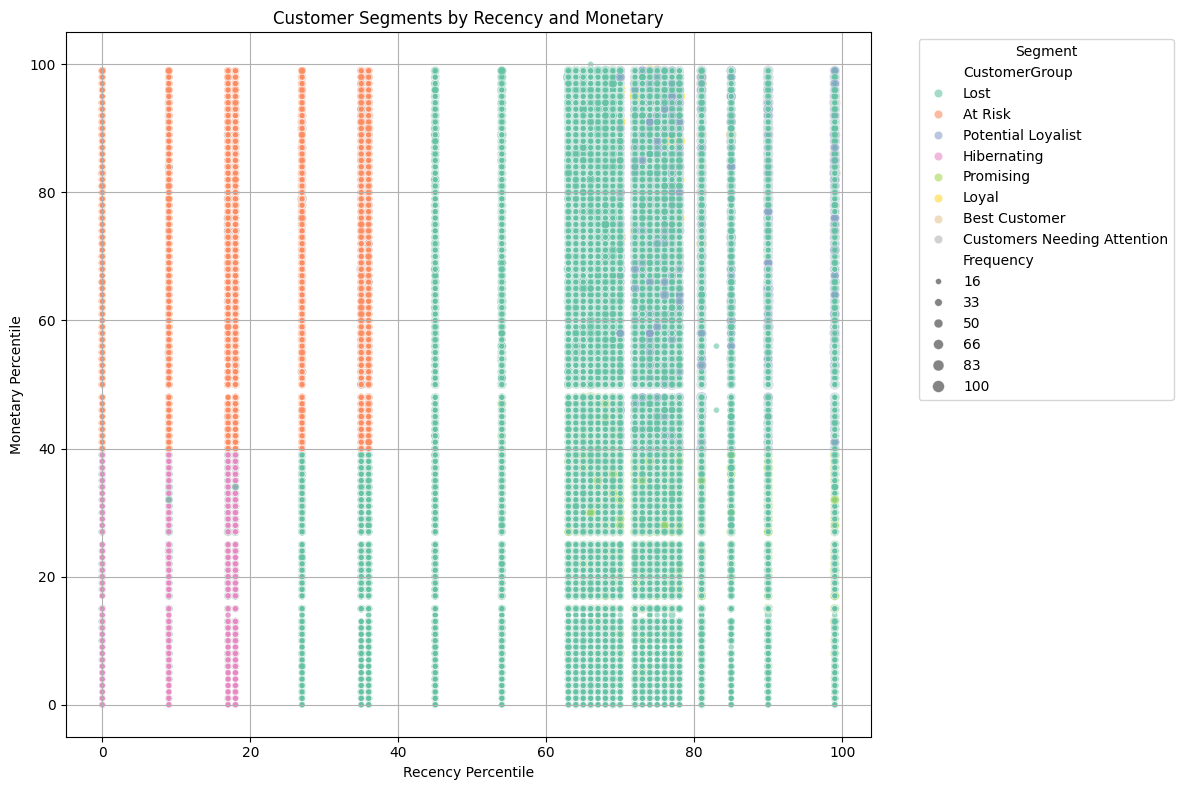

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=normalisedRFM,
    x='Recency',
    y='Monetary',
    hue='CustomerGroup',
    palette='Set2',
    alpha=0.6,
    size='Frequency'
)

plt.title('Customer Segments by Recency and Monetary')
plt.xlabel('Recency Percentile')
plt.ylabel('Monetary Percentile')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

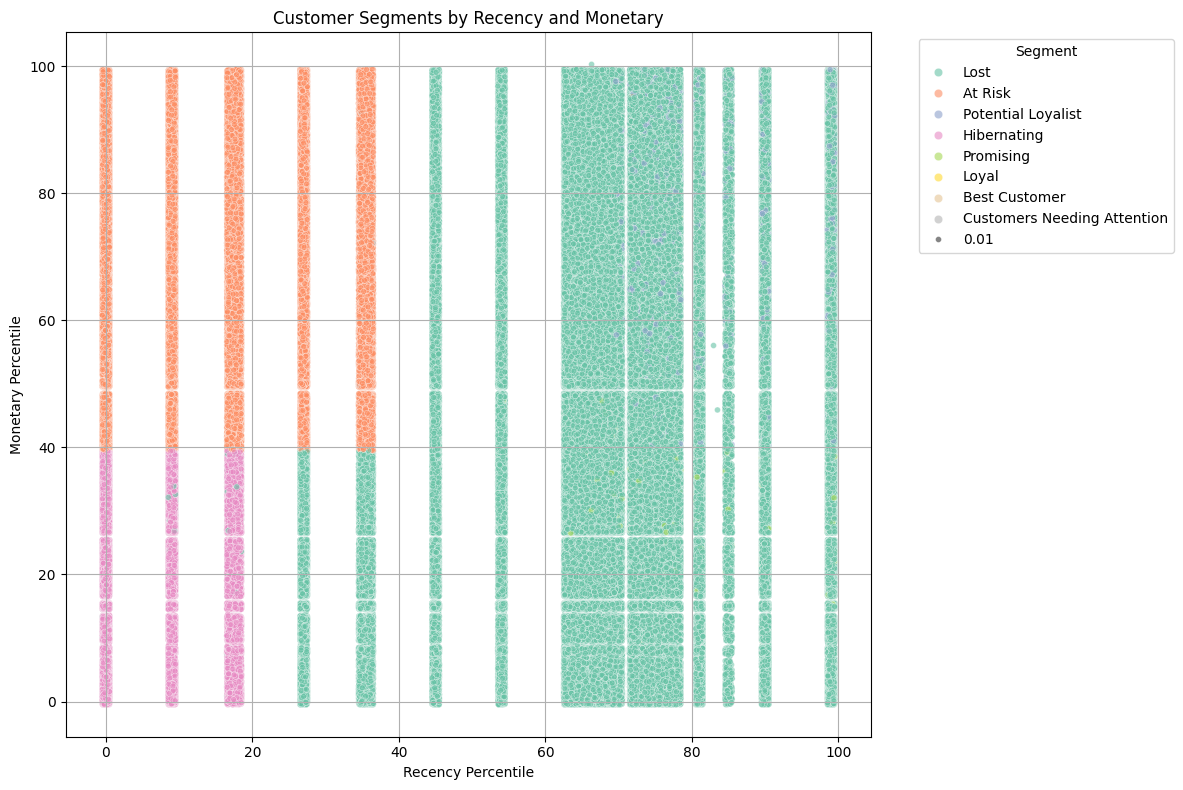

In [14]:
normalisedRFM["Recency_jittered"] = normalisedRFM["Recency"] + numpy.random.uniform(-0.5, 0.5, size=len(normalisedRFM))
normalisedRFM["Monetary_jittered"] = normalisedRFM["Monetary"] + numpy.random.uniform(-0.5, 0.5, size=len(normalisedRFM))

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=normalisedRFM,
    x='Recency_jittered',
    y='Monetary_jittered',
    hue='CustomerGroup',
    palette='Set2',
    alpha=0.6,
    size=0.01
)

plt.title('Customer Segments by Recency and Monetary')
plt.xlabel('Recency Percentile')
plt.ylabel('Monetary Percentile')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

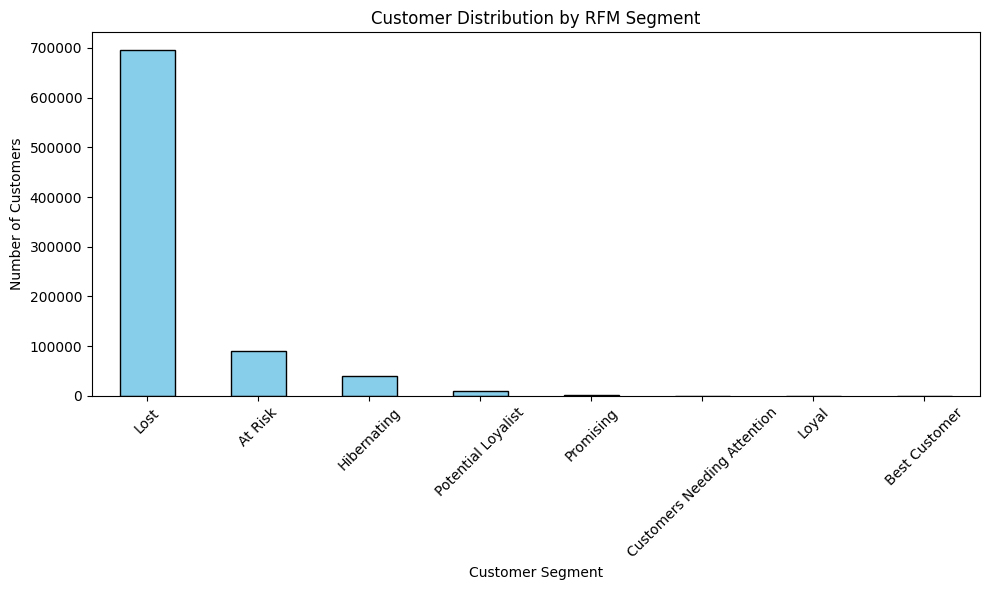

In [15]:
# Histogram

groupCount = normalisedRFM['CustomerGroup'].value_counts()

plt.figure(figsize=(10, 6))
groupCount.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Customer Distribution by RFM Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()